In [3]:
import sys
sys.path.append("..")
from lunar_spectra_workbench.pipeline import analyze_day

res = analyze_day("../data/raw/20230902")


<Axes: xlabel='Pixel'>

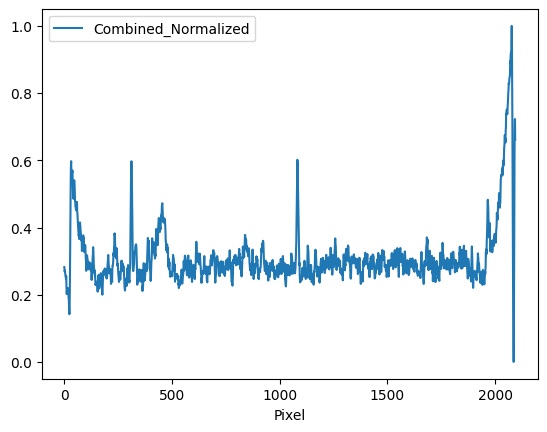

In [2]:
res = analyze_day("../data/raw/20230902")

best_shot = res.shot_quality.sort_values(
    "mean_persistence",
    ascending=False
).iloc[0]["shot_id"]

res.combined_spectra[best_shot].plot(
    x="Pixel",
    y="Combined_Normalized"
)


In [4]:
best_shot = (
    res.shot_quality
      .sort_values("mean_persistence", ascending=False)
      .iloc[0]["shot_id"]
)

best_shot


'ch3_lib_045_20230902T074049_07'

In [6]:
# find the CSV for this shot
from pathlib import Path
from lunar_spectra_workbench.load import load_l0_csv, extract_pixel_columns

csv_path = next(
    p for p in Path("../data/raw/20230902").rglob("*_l0.csv")
    if best_shot in p.name
)

df = load_l0_csv(csv_path)

row = df.iloc[0]   # first sub-frame
pixel_cols = extract_pixel_columns(df)
raw_intensity = row[pixel_cols].astype(float).values
pixels = range(len(raw_intensity))



In [7]:
from lunar_spectra_workbench.clean import clean_subframe

cleaned = clean_subframe(row.to_frame().T)


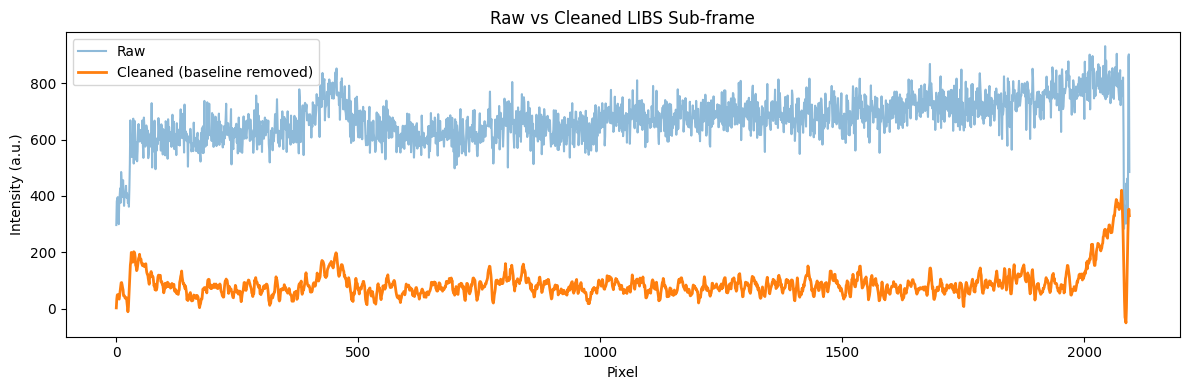

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(pixels, raw_intensity, label="Raw", alpha=0.5)
plt.plot(cleaned["Pixel"], cleaned["Smoothed"], label="Cleaned (baseline removed)", linewidth=2)
plt.xlabel("Pixel")
plt.ylabel("Intensity (a.u.)")
plt.title("Raw vs Cleaned LIBS Sub-frame")
plt.legend()
plt.tight_layout()
plt.show()


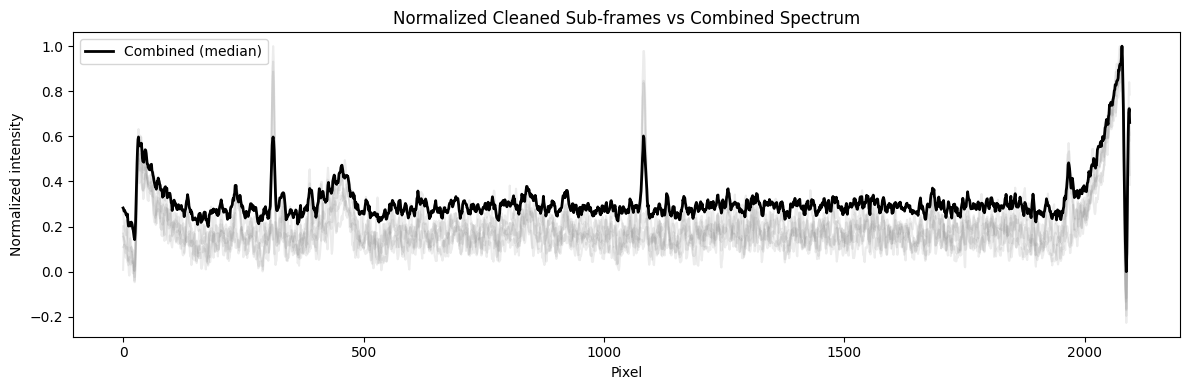

In [11]:
plt.figure(figsize=(12, 4))

# normalize cleaned sub-frames
for sf in cleaned_subframes:
    y = sf["Smoothed"].values
    y = y / y.max()
    plt.plot(
        sf["Pixel"],
        y,
        alpha=0.15,
        color="gray"
    )

# plot combined (already normalized)
plt.plot(
    combined["Pixel"],
    combined["Combined_Normalized"],
    color="black",
    linewidth=2,
    label="Combined (median)"
)

plt.xlabel("Pixel")
plt.ylabel("Normalized intensity")
plt.title("Normalized Cleaned Sub-frames vs Combined Spectrum")
plt.legend()
plt.tight_layout()
plt.show()


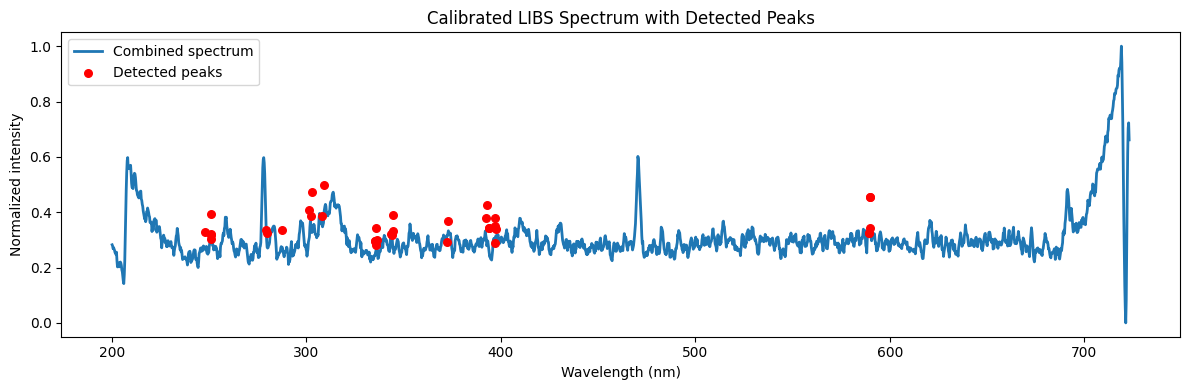

In [13]:
combined = res.combined_spectra[best_shot]

a = res.calibration["a"]
b = res.calibration["b"]

wavelength = a * combined["Pixel"].values + b
shot_matches = res.matches[
    res.matches["shot_id"] == best_shot
]


matched_wavelengths = (
    a * shot_matches["Pixel"].values + b
)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot combined calibrated spectrum
plt.plot(
    wavelength,
    combined["Combined_Normalized"],
    linewidth=2,
    label="Combined spectrum"
)

# Overlay detected peaks
plt.scatter(
    matched_wavelengths,
    shot_matches["Height"].values,
    color="red",
    s=30,
    zorder=3,
    label="Detected peaks"
)

plt.xlabel("Wavelength (nm)")
plt.ylabel("Normalized intensity")
plt.title("Calibrated LIBS Spectrum with Detected Peaks")
plt.legend()
plt.tight_layout()
plt.show()

